In [1]:
import matplotlib.pyplot as plt
import os
if os.environ['USER'] == 'ershockley':
    plt.style.use('evan')

In [5]:
import numpy as np
from numba import njit
# This just ensures some comments in dataframes below display nicely
import pandas as pd
from multihist import Hist1d, Histdd
from tqdm import tqdm
pd.options.display.max_colwidth = 100

In [3]:
import strax
export, __all__ = strax.exporter()

In [6]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [7]:
runs = st.select_runs(include_tags='spe_topbulk')

runs[['number', 'name']]

Checking data availability: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


,number,name
30,16985,180219_1049


In [8]:
dataset = runs['name'].values[0]

In [9]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) - data_orig
8,reduction_level,uint8,Level of data reduction applied (strax.ReductionLevel enum)
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


In [10]:
dataset

'180219_1049'

In [11]:
arr = st.get_array(dataset, 'raw_records', seconds_range=(0, 20))

Not saving raw_records while selecting a time range in the run


In [12]:
arr['data'].shape

(2067306, 600)

In [13]:
ch = 0
arr_ch = arr[arr['channel'] == ch]



In [14]:
def get_wf(arr):
    for el in arr:
        yield el['data']
        
wf_gen = get_wf(arr_ch)

In [15]:
pulse = next(wf_gen)
pulse.shape

(600,)

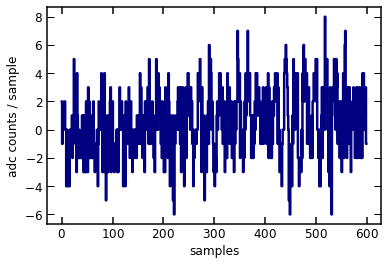

In [26]:
pulse = next(wf_gen)
plt.plot(pulse, drawstyle='steps-mid')
plt.xlabel('samples')
plt.ylabel('adc counts / sample')
plt.show()

In [27]:
from scipy.stats import norm
from scipy.optimize import curve_fit


def gaus(x, *pars):
    N, mu, sigma = pars
    return N*norm.pdf(x, loc=mu, scale=sigma)



In [28]:
channels = np.arange(248)

In [29]:
thresh = 20
off_channels = []
means = []
sigmas = []

for ch in tqdm(channels):
    arr_ch = arr[arr['channel'] == ch]
    amps = []
    for a in arr_ch:
        pulse = a['data']
        amps.append(max(pulse))
        
    # make histogram
    h = Hist1d(amps, bins=np.linspace(0,500,200))

    idx = np.where(h.bin_centers > thresh)[0]
    try:
        fit, cov = curve_fit(gaus, h.bin_centers[idx], h.histogram[idx], p0=[2000, 100, 20])
        means.append(fit[1])
        sigmas.append(fit[2])
        if fit[1] < 15:
            off_channels.append(ch)
    except:
        off_channels.append(ch)
        means.append(0)
        sigmas.append(0)

100%|██████████| 248/248 [02:23<00:00,  1.73it/s]


In [30]:
off_channels

[31, 203, 214]

Text(0.5, 0, 'SPE amplitude mean')

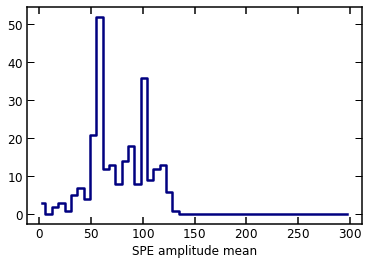

In [31]:
h = Hist1d(means, bins=np.linspace(0, 300, 50))
h.plot()
plt.xlabel('SPE amplitude mean')

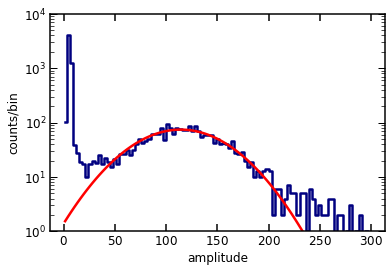

In [32]:
h = Hist1d(amps, bins=np.linspace(0,300,100))

thresh = 20
idx = np.where(h.bin_centers > thresh)[0]

fit, cov = curve_fit(gaus, h.bin_centers[idx], h.histogram[idx], p0=[2000, 100, 20])

h.plot()
plt.plot(h.bin_centers, gaus(h.bin_centers, *fit), color='red')
plt.yscale('log')
plt.ylim(1, 1e4 )
plt.xlabel('amplitude')
plt.ylabel('counts/bin')
plt.show()

In [33]:
h = Histdd(axis_names=['SPE arrival time [samples]', 'channel'], 
           bins=[np.linspace(0, 600, 100), np.linspace(0, 248, 249)])
for ch in tqdm(channels):
    arr_ch = arr[arr['channel'] == ch]
    mu, sig = means[ch], sigmas[ch]
    times = []
    for a in arr_ch:
        pulse = a['data']
        # find regions where amplitude falls in SPE mean region 
        idx = np.where((mu-0.5*sig < pulse) & (pulse < mu + sig))[0]
        times.extend(idx)
    chlist = np.ones_like(times) * ch
    
    h.add(times, chlist)
        

100%|██████████| 248/248 [00:40<00:00,  6.15it/s]


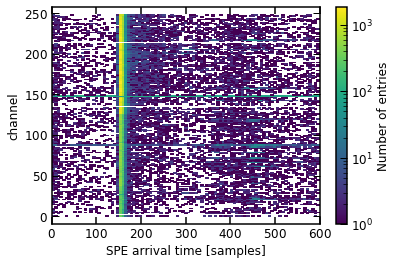

In [34]:
h.plot(log_scale=True)
plt.ylim(-10, 258)
plt.show()

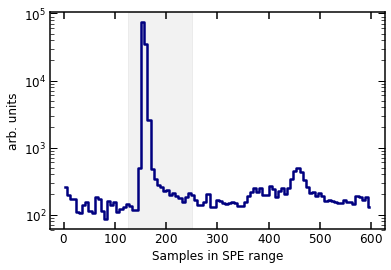

In [35]:
# select only top pmts

window = (125, 250)

hslice = h.slice(0, 148, axis=1)

hproj = hslice.projection(axis=0)

hproj.plot()
plt.yscale('log')
plt.xlabel("Samples in SPE range")
plt.ylabel('arb. units')
plt.axvspan(*window, color='grey', alpha=0.1)
plt.show()

In [62]:
ctext = straxen.contexts.strax_workshop_dali()
raw_records  = ctext.get_array(dataset, 'raw_records', seconds_range=(0, 20))

Not saving raw_records while selecting a time range in the run


In [106]:
@njit
def get_amplitude(raw_records, window):
    ret = np.zeros(len(raw_records))
    for i, r in enumerate(raw_records):
        wf = r['data'][window[0]:window[1]]
        amp = wf.max()
        ret[i] = amp
    return ret
        

In [107]:
%%timeit
ret = get_amplitude(raw_records, (125,250))


209 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
@export
@strax.takes_config(
    strax.Option(
        'LED_window',
        default=(125, 250),
        help="Window (samples) where we expect signal in LED calibration"))

class LEDCal(strax.Plugin):
    __version__ = '0.0.1'

    depends_on = ('raw_records',)
    data_kind = 'records'
    provides = 'led_cal'
    compressor = 'zstd'
    parallel = 'process'
    rechunk_on_save = False
    dtype = [('amplitude', np.int32, 'Amplitude in LED window'),
             ('channel', np.int16, 'Channel'),
             ('time', np.int64, 'Start time of the interval (ns since unix epoch)'),
             ('length', np.int32, 'Number of samples of record'),
             ('dt', np.int8, 'ns per sample')
            ]

    def compute(self, raw_records):
        # Remove records from funny channels (if present)
        r = raw_records[raw_records['channel'] < 248] # hardcoded for now
        
        ret = np.zeros(len(r), dtype=self.dtype)
        
        amplitudes = get_amplitude(r, self.config['LED_window'])
        
        ret['amplitude'] = amplitudes
        ret['channel'] = r['channel']
        ret['time'] = r['time']
        ret['length'] = r['length']
        ret['dt'] = r['dt']
        return np.array(ret, dtype=self.dtype)
            


In [124]:
ctext.register(LEDCal)

__main__.LEDCal

In [125]:
ctext.data_info('led_cal')

,Field name,Data type,Comment
0,amplitude,int32,Amplitude in LED window
1,channel,int16,Channel
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Number of samples of record
4,dt,int8,ns per sample


In [135]:
noise = ctext.select_runs(include_tags=['gain_step4'])['name'].values[0]
noise

'180219_1030'

In [136]:
ctext.make(noise, 'led_cal')

In [137]:
led = ctext.get_array(dataset, 'led_cal', seconds_range=(0,20))
noise = ctext.get_array(noise, 'led_cal', seconds_range=(0,20))

Not saving led_cal while selecting a time range in the run
Not saving led_cal while selecting a time range in the run


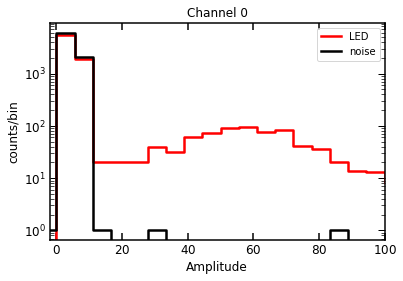

In [143]:
ch = 0
led = led[led['channel'] == ch]
noise = noise[noise['channel'] == ch]

led_h = Hist1d(led['amplitude'], bins=np.linspace(-50, 500, 100))
noise_h = Hist1d(noise['amplitude'], bins=np.linspace(-50, 500, 100))

led_h.plot(color='r', label='LED')
noise_h.plot(color='k', label='noise')
plt.yscale('log')
plt.title(f"Channel {ch}")
plt.xlabel("Amplitude")
plt.ylabel("counts/bin")
plt.legend()
plt.xlim(-2, 100)
plt.show()